In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from bearing_walls import *
import random
from colored_space import *
from external_wall_contours import *
from colored_space import *
from textual_layer import *

In [18]:
image_path = "/Users/areebakamil/PycharmProjects/floorPlanAnalysis/Data/floorplans_VOA_cropped/DFirstFloor_cropped.png"
image = cv2.imread(image_path)

words_list = ['bedroom', 'master', 'living', 'family', 'bathroom','bath','shower','reception',
              'kitchen', 'dining',
              'office', 'study', 'utility', 'pantry',
              'laundry', 'lndry','conservatory', 'garage', 'lounge','hall','hallway', 'porch', 'en-suite',
              'w/c', 'wc','ec','e/s','stairs', 'staircase', 'cupboard', 'lift', 'lobby']

alphabets = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')

spell = SpellChecker()

args = {"east": "frozen_east_text_detection.pb",
        "min_confidence": 0.5,
        "width": 320,
        "height": 320}


In [19]:
# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []

    # loop over rows
    for y in range(0, numR):
        scoresData = prob_score[0, 0, y]
        x0 = geo[0, 0, y]
        x1 = geo[0, 1, y]
        x2 = geo[0, 2, y]
        x3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for i in range(0, numC):
            if scoresData[i] < args["min_confidence"]:
                continue

            (offX, offY) = (i * 4.0, y * 4.0)

            # extracting the rotation angle for the prediction and computing the sine and cosine
            angle = anglesData[i]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # using the geo volume to get the dimensions of the bounding box
            h = x0[i] + x2[i]
            w = x1[i] + x3[i]

            # compute start and end for the text pred bbox
            endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
            endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
            startX = int(endX - w)
            startY = int(endY - h)

            boxes.append((startX, startY, endX, endY))
            confidence_val.append(scoresData[i])

    # return bounding boxes and associated confidence_val
    return (boxes, confidence_val)

In [20]:
a,b,c = image.shape
blank_img = np.ones([a, b, c], dtype=np.uint8)
blank_img.fill(255)

# TEXT DETECTION

# Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.
(newW, newH) = (args["width"], args["height"])

# Calculate the ratio between original and new image for both height and weight.
# This ratio will be used to translate bounding box location on the original image.
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

# load the pre-trained EAST model for text detection
net = cv2.dnn.readNet(args["east"])

# The following two layer need to pulled from EAST model for achieving this.
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)


In [21]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # extract the region of interest
    r = orig[startY:endY, startX:endX]

    #display regions of interests on blank image
    blank_img[startY:endY, startX:endX] = orig[startY:endY, startX:endX]

    # configuration setting to convert image to string.
    configuration = ("-l eng --oem 1 --psm 8")
    # TEXT RECOGNITION
    ##This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(r, config=configuration)

    # append bbox coordinate and associated text to the list of results
    results.append(((startX, startY, endX, endY), text))

# Display the image with bounding box and recognized text
orig_image = orig.copy()

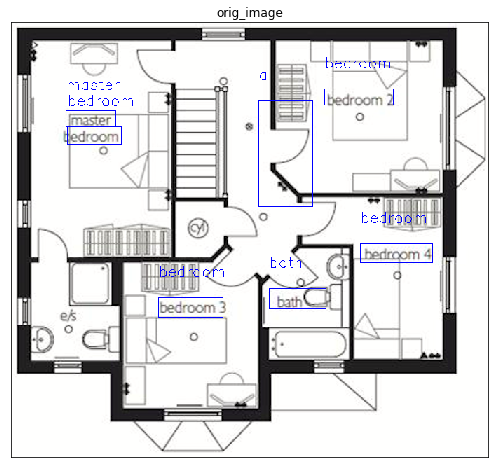

In [22]:
text_list = []
# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
    # display the text detected by Tesseract
    misspelled_word = ''.join(filter(alphabets.__contains__, text))
    final_word = spell.correction(misspelled_word)
    # print("{}\n".format(text))
    text_list.append(final_word)


    # Displaying text
    text = "".join([x if ord(x) < 128 else "" for x in final_word]).strip()
    cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
                  (0, 0, 255), 1)
    cv2.putText(orig_image, text, (start_X, start_Y - 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    


plt.figure(figsize = (60,8))
plt.imshow(orig_image, cmap='gray')
plt.title('orig_image')
plt.xticks([]), plt.yticks([])
plt.show()

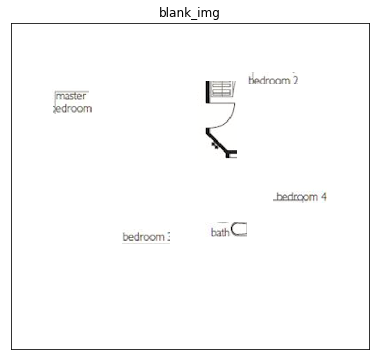

In [23]:
plt.figure(figsize = (60,6))
plt.imshow(blank_img, cmap='gray')
plt.title('blank_img')
plt.xticks([]), plt.yticks([])
plt.show()

In [24]:
# print the text detected
print("\nText Detected:")
print(text_list)

cleaned_list = []
corrected_list = []
words_to_keep = []

discard_list = []

for detected_word in text_list:
    check = False
    for word in words_list:
        if word in detected_word.lower():
            check = True
            words_to_keep.append(word)
            continue
    if check is False:
        discard_list.append(detected_word)

print("\nDiscarded List:")
print(discard_list)


print("\nExtra Text discarded:")
print(words_to_keep)

# count the number of rooms detected
print("\nCount of the number of rooms detected:")
final_count = Counter(words_to_keep)
for key, value in final_count.items():
    print(key + ": ", value)




Text Detected:
['master', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bath', 'a']

Discarded List:
['a']

Extra Text discarded:
['master', 'bedroom', 'bedroom', 'bedroom', 'bedroom', 'bath']

Count of the number of rooms detected:
master:  1
bedroom:  4
bath:  1
